# Preparing data

We use the hourly data for bitcoin prices and volume from 2018-05-15 to 2022-03-01.

In [1]:
from data_handler import get_bitcoin_data

bitcoin_df = get_bitcoin_data()
bitcoin_df.head()

,unix,open,high,low,close,Volume BTC,Volume USD
0,1646092800,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


At first we calculate the Mahalanobis distance for each data point. We will use the distance to detect the outliers in the data price values.
The mahanalobis distance is calculated as follows:

$$
D = \sqrt{(X - \mu)^T \Sigma^{-1} (X - \mu)}
$$

where $X$ is the data point, $\mu$ is the mean value and $\Sigma$ is the covariance matrix.

In [2]:
INTERVAL_DAYS = 150

In [3]:
from data_handler import apply_mahalanobis_interval, index_by_datetime

# Apply the Mahalanobis to the bitcoin data for intervals of 150 days
bitcoin_df = apply_mahalanobis_interval(bitcoin_df, interval_days=INTERVAL_DAYS)

# Set the datetime as the index
bitcoin_df = index_by_datetime(bitcoin_df)

bitcoin_df.head()

,unix,open,high,low,close,Volume BTC,Volume USD,interval,MD
datetime,,,,,,,,,
2022-03-01 00:00:00,1646092800,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06,10,1.940364
2022-02-28 23:00:00,1646089200,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06,10,1.914923
2022-02-28 22:00:00,1646085600,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07,10,1.869486
2022-02-28 21:00:00,1646082000,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06,10,1.736784
2022-02-28 20:00:00,1646078400,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07,10,1.750101


## Evaluating prices

The close prices and mean values used to calculate the Mahalanobis distance are plotted below. 

The red line represents the interval mean value for the Mahalanobis distance.

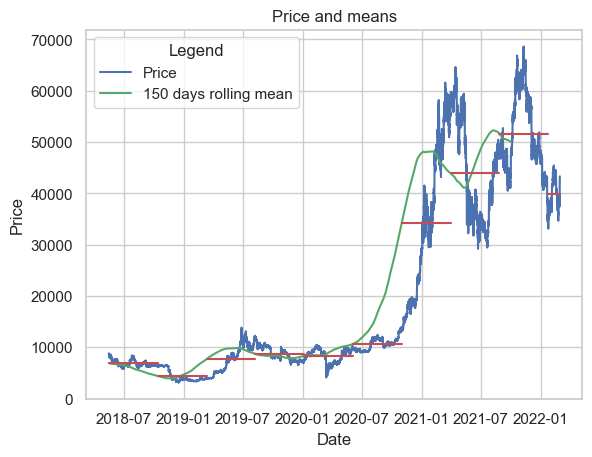

In [4]:
from data_plot import plot_price, plot_mahalanobis_intervals, plot_mahalanobis_distribution

plot_price(bitcoin_df)

The mahalanobis distance is plotted below. Each color represents a different data interval.

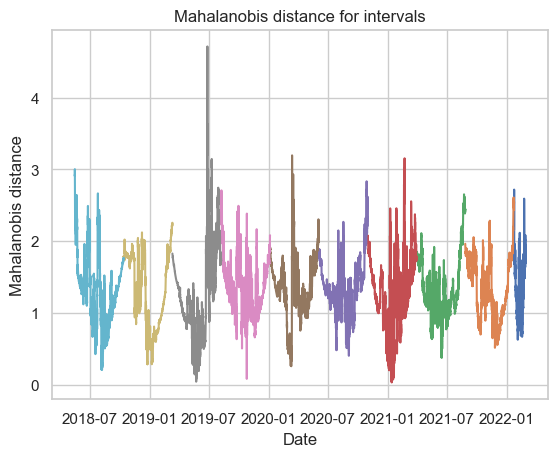

In [5]:
plot_mahalanobis_intervals(bitcoin_df)

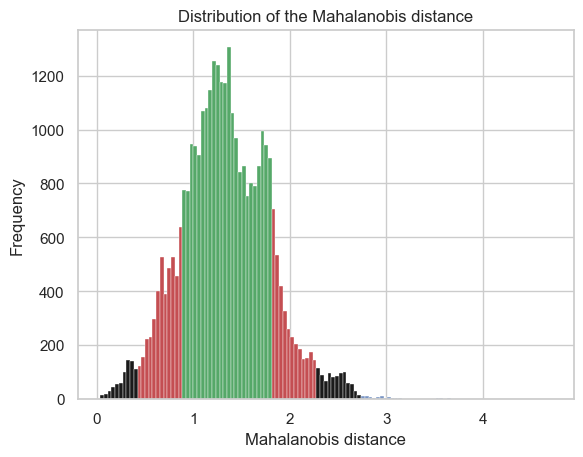

In [6]:
plot_mahalanobis_distribution(bitcoin_df)

## Evaluating volumes

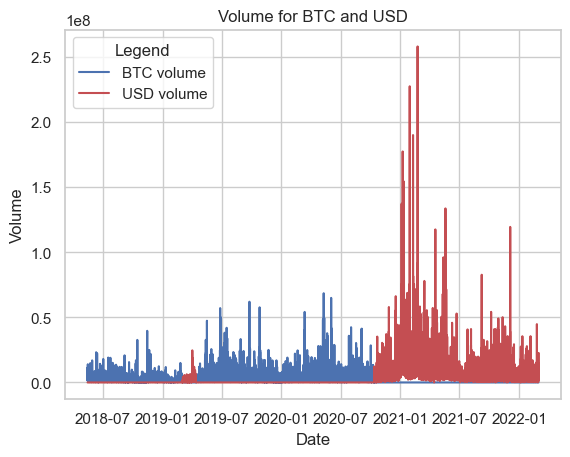

In [7]:
from data_plot import plot_volume, plot_price_volume_corelation
plot_volume(bitcoin_df)

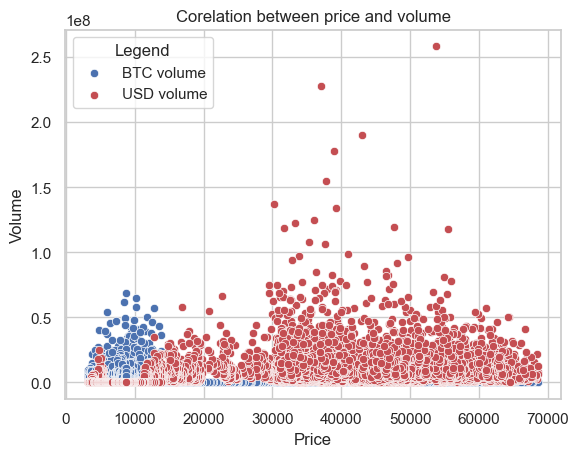

In [8]:
plot_price_volume_corelation(bitcoin_df)

## Defining anomalies

Searching for the outliers in the data.

In [9]:
# Get values that are outliers over 4 standard deviations
std = bitcoin_df['MD'].std()
mean = bitcoin_df['MD'].mean()
outliers = bitcoin_df.loc[bitcoin_df['MD'] > mean + 4 * std]

outliers.count()

unix          26
open          26
high          26
low           26
close         26
Volume BTC    26
Volume USD    26
interval      26
MD            26
datetime      26
dtype: int64

In [10]:
outliers.describe()

,unix,open,high,low,close,Volume BTC,Volume USD,interval,MD,datetime
count,2.600000e+01,26.000000,26.000000,26.000000,26.000000,2.600000e+01,26.000000,26.000000,26.000000,26
mean,1.562433e+09,12510.165000,12704.406154,12219.369615,12518.953462,1.884344e+07,1524.015385,3.076923,3.646485,2019-07-06 17:06:55.384615424
min,1.561522e+09,4671.370000,4773.930000,4007.140000,4111.780000,3.605153e+06,283.540000,3.000000,3.195589,2019-06-26 04:00:00
25%,1.561548e+09,12445.407500,12747.902500,12374.810000,12575.425000,9.956750e+06,830.952500,3.000000,3.385137,2019-06-26 11:15:00
50%,1.561570e+09,12740.550000,12872.125000,12493.665000,12762.730000,1.499749e+07,1280.745000,3.000000,3.563455,2019-06-26 17:30:00
75%,1.561593e+09,12884.475000,13202.232500,12712.455000,12884.475000,2.196797e+07,1734.535000,3.000000,3.700120,2019-06-26 23:45:00
max,1.584061e+09,13837.960000,13880.000000,13550.000000,13837.960000,5.713718e+07,4550.520000,5.000000,4.712135,2020-03-13 01:00:00
std,4.411425e+06,1653.642159,1669.111801,1720.086859,1759.933159,1.333813e+07,1044.195267,0.392232,0.429685,NaN
